   TransactionID  id_01     id_02  id_03  id_04  id_05  id_06  id_07  id_08  \
0        2987004    0.0   70787.0    NaN    NaN    NaN    NaN    NaN    NaN   
1        2987008   -5.0   98945.0    NaN    NaN    0.0   -5.0    NaN    NaN   
2        2987010   -5.0  191631.0    0.0    0.0    0.0    0.0    NaN    NaN   
3        2987011   -5.0  221832.0    NaN    NaN    0.0   -6.0    NaN    NaN   
4        2987016    0.0    7460.0    0.0    0.0    1.0    0.0    NaN    NaN   

   id_09  ...                id_31  id_32      id_33           id_34  id_35  \
0    NaN  ...  samsung browser 6.2   32.0  2220x1080  match_status:2      T   
1    NaN  ...   mobile safari 11.0   32.0   1334x750  match_status:1      T   
2    0.0  ...          chrome 62.0    NaN        NaN             NaN      F   
3    NaN  ...          chrome 62.0    NaN        NaN             NaN      F   
4    0.0  ...          chrome 62.0   24.0   1280x800  match_status:2      T   

  id_36 id_37  id_38  DeviceType                  

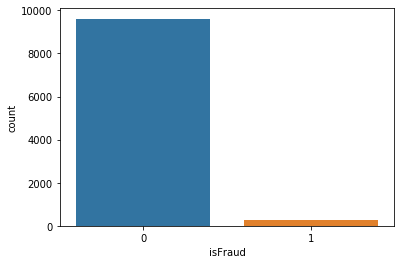

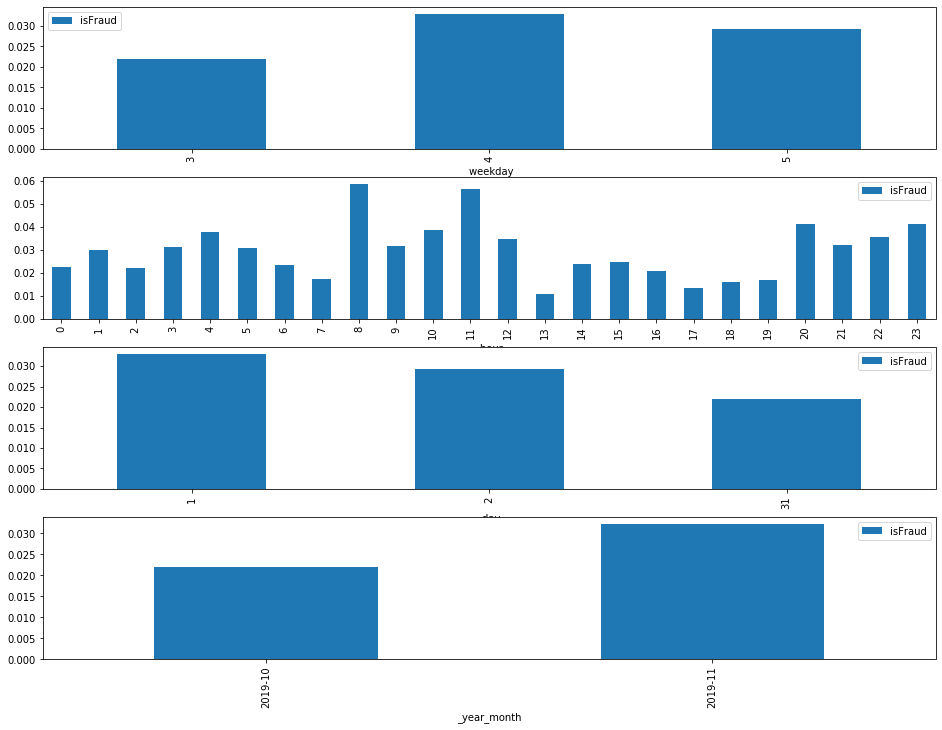

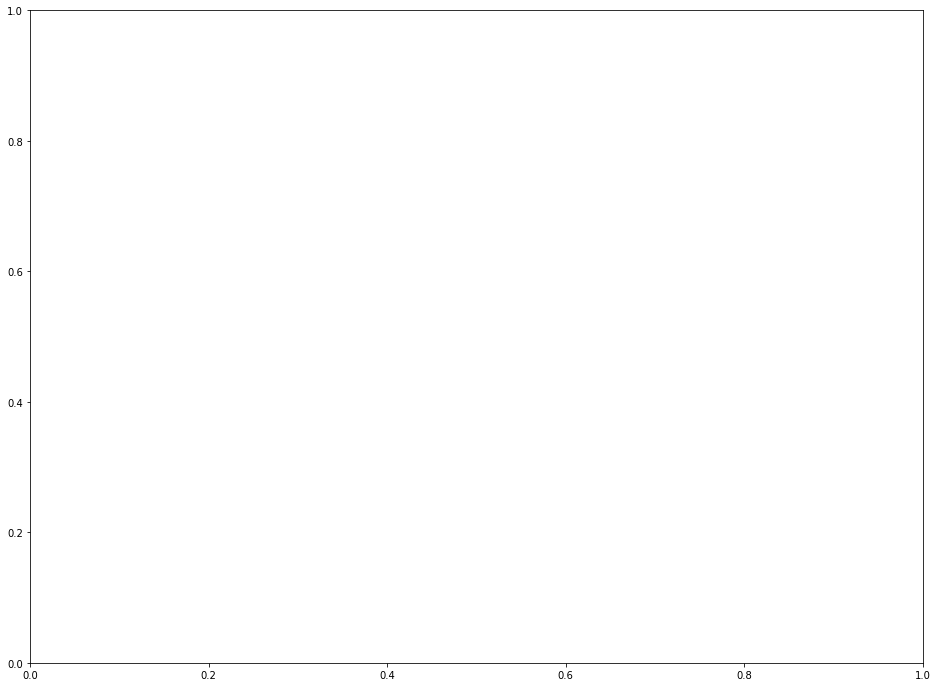

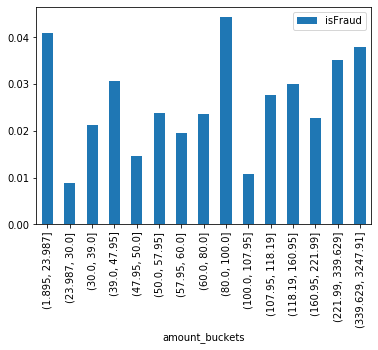

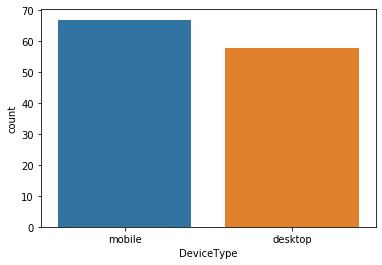

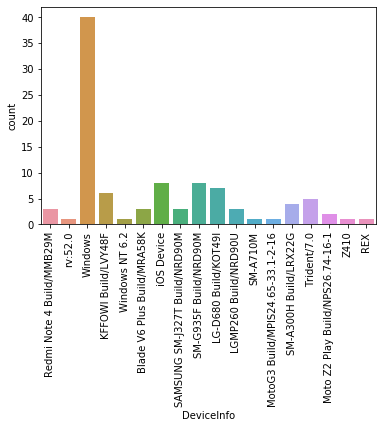

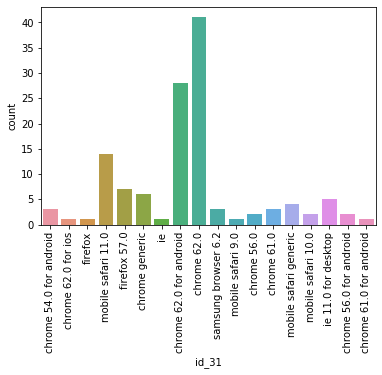

/Users/bkumar/CreditCardFraud/venv/lib/python3.7/site-packages/ipykernel_launcher.py:130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


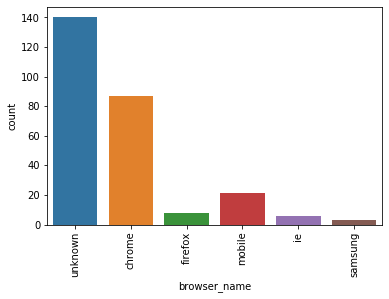

In [2]:
import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

### Load data
train_identity = pd.read_csv('train_identity.csv')
train_transaction = pd.read_csv('train_transaction.csv')
test_identity = pd.read_csv('test_identity.csv')
test_transaction = pd.read_csv('test_transaction.csv')

print(train_identity.head())
print(train_transaction.head())

# As we can see, that transactionId exists in both datasets. So let's combine the data and identity and transactions
# dataset by joining this TransactionId column
train = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')
test = pd.merge(test_transaction, test_identity, on='TransactionID', how='left')

# Now lets check the total number of rows and columns of the finalized dataset.
print(train.shape)
print(test.shape)
# print(train.head())
# print(train.describe())

# Lets Check the class values distribution
sns.countplot(x='isFraud', data=train)
plt.show()
train_fraud = train['isFraud']
print(train['isFraud'].value_counts(normalize=True))

# reduce_mem_usage(train)
# reduce_mem_usage(test)
# As we have merged the identity and trasactions data, lets delete the other dataframes to save memory.
del train_identity, train_transaction, test_identity, test_transaction

### Data cleaning and selection

print(train.isnull().sum())
print('null values in test data:')
print(test.isnull().sum())

# Work on Categorical values
categorical_columns = train.select_dtypes(include=['object']).columns
print(categorical_columns)
# Now we are creating a new dataframe to identify the columns with no useful data or no values at all.
# We can delete all the columns with only null/nan values
data_null = train.isnull().sum() / len(train) * 100
data_null.drop(data_null[data_null == 0].index).sort_values(ascending=False)[:500]
missing_data = pd.DataFrame({'Missing Ratio': data_null})
missing_data.head()


def get_too_many_null_attr(data):
    many_null_cols = [col for col in data.columns if data[col].isnull().sum() / data.shape[0] > 0.9]
    return many_null_cols


def get_too_many_repeated_val(data):
    big_top_value_cols = [col for col in train.columns if
                          data[col].value_counts(dropna=False, normalize=True).values[0] > 0.9]
    return big_top_value_cols


print(train.shape)
too_many_null = get_too_many_null_attr(train)
print("More than 90% null: " + str(len(too_many_null)))
train.drop(too_many_null, axis=1, inplace=True)
too_many_repeated = get_too_many_repeated_val(train)
print("More than 90% repeated value: " + str(len(too_many_repeated)))
train.drop(too_many_repeated, axis=1, inplace=True)
print(train.shape)
print(list(train.columns))

# Add back the isFraud class label
train['isFraud'] = train_fraud

# As seen above, we are able to reduce the number of dimensions from 434 to 355 just by eliminating the null columns and highly repaeated
# same values in the columns.

### Exploratory Data Analysis
# 1. Lets check the times, days and months  on which the frauds happened more often
# The Transaction dates in the dataset are just the relative times from the starting transaction.
# 86400 // 24 * 60 * 60
start_date = datetime.datetime.strptime('2019-10-30', "%Y-%m-%d")
train['Date'] = train['TransactionDT'].apply(lambda x: (start_date + datetime.timedelta(seconds=x)))
train['_year_month'] = train['Date'].dt.year.astype(str) + '-' + train['Date'].dt.month.astype(str)
train['_weekday'] = train['Date'].dt.dayofweek
train['_hour'] = train['Date'].dt.hour
train['_day'] = train['Date'].dt.day

fig, ax = plt.subplots(4, 1, figsize=(16, 12))

train.groupby('_weekday')['isFraud'].mean().to_frame().plot.bar(ax=ax[0])
train.groupby('_hour')['isFraud'].mean().to_frame().plot.bar(ax=ax[1])
train.groupby('_day')['isFraud'].mean().to_frame().plot.bar(ax=ax[2])
train.groupby('_year_month')['isFraud'].mean().to_frame().plot.bar(ax=ax[3])

plt.show()

# 2. Lets check the amounts ranges on which there are more frauds
# Discretize the amounts into 15 buckets and visualize on which buckets, there are more frauds
train['amount_buckets'] = pd.qcut(train['TransactionAmt'], 15)
df = train.groupby('amount_buckets')['isFraud'].mean().to_frame()
df.sort_values(by='isFraud', ascending=False)
print(df)

fig, ax = plt.subplots(1, 1, figsize=(16, 12))
df.plot.bar()
plt.show()

# Device Type Analysis
train_fraud_subset = train[train.isFraud==True]
sns.countplot(x='DeviceType', data=train_fraud_subset)
plt.show()

# Device Info Analysis
device_info_plots = sns.countplot(x='DeviceInfo', data=train_fraud_subset)
device_info_plots.set_xticklabels(device_info_plots.get_xticklabels(), rotation=90)
plt.show()

# Browser Type Analysis
browser_count_plot = sns.countplot(x='id_31', data=train_fraud_subset)
browser_count_plot.set_xticklabels(browser_count_plot.get_xticklabels(), rotation=90)
plt.show()

# Browser Aggregations based on its product/company name
train_fraud_subset['browser_name'] = train_fraud_subset['id_31'].apply(lambda x: x.split()[0] if x == x else 'unknown')
browser_count_plot = sns.countplot(x='browser_name', data=train_fraud_subset)
browser_count_plot.set_xticklabels(browser_count_plot.get_xticklabels(), rotation=90)
plt.show()

